In [1]:
%matplotlib inline
import calendar
import matplotlib.pyplot as plt
plt.style.use('my_custom_style')
import pandas as pd
from sqlalchemy import create_engine
from datetime import date, timedelta
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from itables import show
pd.options.display.max_rows = 31

engine = create_engine("sqlite:///c:\\ruby\\expense\\db\\development.sqlite3")
conn = engine.connect()

today = date.today()
print(today)

2026-01-03


In [3]:
# Define a formatting function that converts a float to a string with two decimal places
def to_currency(x):
    return '฿{:,.2f}'.format(x)    

# Define a formatting function that converts an integer to a string with comma and no decimal places
def to_integer(x):
    return '{:,.0f}'.format(x)

In [5]:
sql = "SELECT C.id, C.name AS item, G.name AS kind, G.id FROM categories C \
       JOIN groups G ON group_id = G.id"
df_c = pd.read_sql(sql, conn)
df_c.head()

,id,item,kind,id
0,1,Books & Software,Edutainment,3
1,2,CCF,Luxury,5
2,3,Cigarette,Luxury,5
3,4,Food,Food,4
4,5,Fuel,Transportation,10


In [7]:
# create a date object
date = pd.to_datetime('2025-12-31')

# find the beginning of the month for the given date
bom = date.to_period('M').start_time
eom = date.to_period('M').end_time
bom = bom.date()
eom = eom.date()
print(f'Month start: {bom}')
print(f'Month end: {eom}')

Month start: 2025-12-01
Month end: 2025-12-31


In [9]:
sqlEom = """
    SELECT date,amount,C.name AS item, G.name AS kind 
    FROM transactions T 
    JOIN categories C ON category_id = C.id 
    JOIN groups G ON group_id = G.id 
    WHERE date = "{}" 
    ORDER BY amount DESC
""".format(eom)
#print(sqlEom)

df_transactions_eom = pd.read_sql(sqlEom, conn)
df_transactions_eom

,date,amount,item,kind
0,2025-12-31,5000,Parent,Parent
1,2025-12-31,640,Books & Software,Edutainment
2,2025-12-31,520,Netflix,Edutainment
3,2025-12-31,510,Internet Home,Communication
4,2025-12-31,320,Telephone Dtac,Communication
5,2025-12-31,240,Apple,Edutainment
6,2025-12-31,170,Google,Edutainment


In [11]:
df_transactions_eom[['amount']] = df_transactions_eom[['amount']].apply(lambda col: col.map(to_currency))
df_transactions_eom

,date,amount,item,kind
0,2025-12-31,"฿5,000.00",Parent,Parent
1,2025-12-31,฿640.00,Books & Software,Edutainment
2,2025-12-31,฿520.00,Netflix,Edutainment
3,2025-12-31,฿510.00,Internet Home,Communication
4,2025-12-31,฿320.00,Telephone Dtac,Communication
5,2025-12-31,฿240.00,Apple,Edutainment
6,2025-12-31,฿170.00,Google,Edutainment


In [13]:
df_transactions_eom = pd.read_sql(sqlEom, conn)
total_eom_amt = df_transactions_eom.amount.sum()
total_eom_fmt = to_currency(total_eom_amt)  # Apply the function directly to the scalar
print(total_eom_fmt)

฿7,400.00


In [15]:
sql = """
    SELECT date,amount,C.name AS item, G.name AS kind 
    FROM transactions T 
    JOIN categories C ON category_id = C.id 
    JOIN groups G ON group_id = G.id 
    WHERE date BETWEEN "{}" AND "{}" 
    ORDER BY date
""".format(bom, eom)
#print(sql)

df_month = pd.read_sql(sql, conn)
df_month

,date,amount,item,kind
0,2025-12-05,250,Personal Care,Apparel
1,2025-12-11,1850,Food,Food
2,2025-12-16,420,Transportation,Transportation
3,2025-12-24,1440,Medicine,Medicine
4,2025-12-26,690,Books & Software,Edutainment
5,2025-12-31,5000,Parent,Parent
6,2025-12-31,510,Internet Home,Communication
7,2025-12-31,520,Netflix,Edutainment
8,2025-12-31,320,Telephone Dtac,Communication
9,2025-12-31,170,Google,Edutainment


In [17]:
df_month[['amount']] = df_month[['amount']].apply(lambda col: col.map(to_currency))
df_month

,date,amount,item,kind
0,2025-12-05,฿250.00,Personal Care,Apparel
1,2025-12-11,"฿1,850.00",Food,Food
2,2025-12-16,฿420.00,Transportation,Transportation
3,2025-12-24,"฿1,440.00",Medicine,Medicine
4,2025-12-26,฿690.00,Books & Software,Edutainment
5,2025-12-31,"฿5,000.00",Parent,Parent
6,2025-12-31,฿510.00,Internet Home,Communication
7,2025-12-31,฿520.00,Netflix,Edutainment
8,2025-12-31,฿320.00,Telephone Dtac,Communication
9,2025-12-31,฿170.00,Google,Edutainment


In [19]:
df_month = pd.read_sql(sql, conn)
grouped_by_item = df_month.groupby("item")[["amount"]].sum()
grouped_by_item

,amount
item,
Apple,240
Books & Software,1330
Food,1850
Google,170
Internet Home,510
Medicine,1440
Netflix,520
Parent,5000
Personal Care,250


In [21]:
item_fmt = grouped_by_item.map(to_currency)
print(item_fmt)

                     amount
item                       
Apple               ฿240.00
Books & Software  ฿1,330.00
Food              ฿1,850.00
Google              ฿170.00
Internet Home       ฿510.00
Medicine          ฿1,440.00
Netflix             ฿520.00
Parent            ฿5,000.00
Personal Care       ฿250.00
Telephone Dtac      ฿320.00
Transportation      ฿420.00


In [23]:
df_month = pd.read_sql(sql, conn)
grouped_by_kind = df_month.groupby("kind")[["amount"]].sum()
grouped_by_kind

,amount
kind,
Apparel,250
Communication,830
Edutainment,2260
Food,1850
Medicine,1440
Parent,5000
Transportation,420


In [25]:
kind_fmt = grouped_by_kind.map(to_currency)
print(kind_fmt)

                   amount
kind                     
Apparel           ฿250.00
Communication     ฿830.00
Edutainment     ฿2,260.00
Food            ฿1,850.00
Medicine        ฿1,440.00
Parent          ฿5,000.00
Transportation    ฿420.00


In [27]:
expense = grouped_by_kind.amount.sum()
expense_fmt = to_currency(expense)
print(expense_fmt)

฿12,050.00


<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

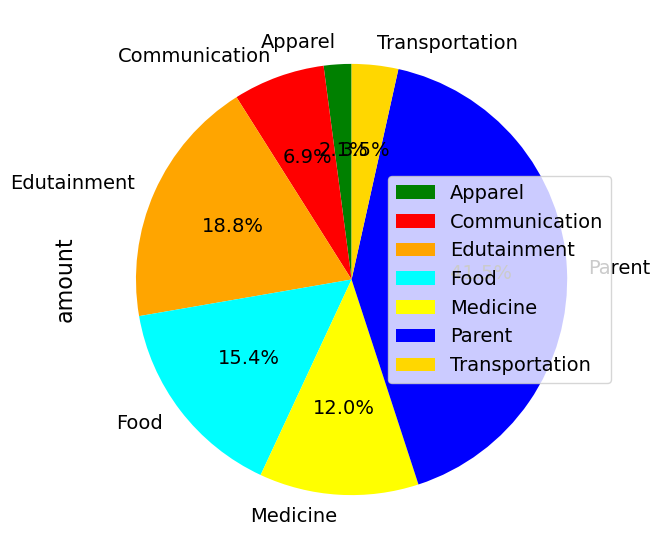

In [29]:
df_month = pd.read_sql(sql, conn)
grouped_by_kind = df_month.groupby("kind")[["amount"]].sum()

# Use the grouped DataFrame for plotting, not the sum of it
fig_path = "../fig/Expense-2512.png"
with plt.style.context("my_custom_style"):
    plt.figure(figsize=(12, 12))
    ax = grouped_by_kind.plot.pie(  # Plot from grouped_by_kind instead of expense
        y="amount",                 # Specify which column to use for pie sizes
        colors=["green", "red", "orange", "cyan", "yellow", "blue", "gold"],
        startangle=90,
        autopct="%1.1f%%",
    )
    plt.savefig(fig_path)
    plt.show()

In [31]:
grouped_by_kind.to_csv("../data/expense-2512.csv")

In [33]:
sql = """
    SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
    JOIN categories C ON category_id = C.id 
    JOIN groups G ON group_id = G.id 
    WHERE date = "{}" 
    ORDER BY date
""".format(eom)
print(sql)


    SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
    JOIN categories C ON category_id = C.id 
    JOIN groups G ON group_id = G.id 
    WHERE date = "2025-12-31" 
    ORDER BY date



In [35]:
df_tmp = pd.read_sql(sql, conn)
show(df_tmp[['date','amount','item','kind']])

In [37]:
df_tmp.to_csv("../data/expense-eom.csv")

In [39]:
sql = "SELECT * FROM groups"
df_groups = pd.read_sql(sql, conn)
df_groups.dtypes

id             int64
name          object
created_at    object
updated_at    object
factor4       object
dtype: object

In [41]:
df_groups

,id,name,created_at,updated_at,factor4
0,1,Apparel,2016-01-01 13:38:53.119230,2016-01-01 13:38:53.119230,2
1,2,Communication,2016-01-01 13:38:53.199234,2016-01-01 13:38:53.199234,5
2,3,Edutainment,2016-01-01 13:38:53.289240,2016-01-01 13:38:53.289240,6
3,4,Food,2016-01-01 13:38:53.356243,2016-01-01 13:38:53.356243,1
4,5,Luxury,2016-01-01 13:38:53.422247,2016-01-01 13:38:53.422247,6
5,6,Medicine,2016-01-01 13:38:53.498252,2016-01-01 13:38:53.498252,4
6,7,Others,2016-01-01 13:38:53.564255,2016-01-01 13:38:53.564255,6
7,8,Parent,2016-01-01 13:38:53.622259,2016-01-01 13:38:53.622259,7
8,9,Shelter,2016-01-01 13:38:53.689263,2016-01-01 13:38:53.689263,3
9,10,Transportation,2016-01-01 13:38:53.764267,2016-01-01 13:38:53.764267,5


In [43]:
sql = "SELECT * FROM categories"
categories = pd.read_sql(sql, conn)
categories.dtypes

id             int64
sequence       int64
name          object
default        int64
group_id       int64
created_at    object
updated_at    object
dtype: object

In [45]:
categories

,id,sequence,name,default,group_id,created_at,updated_at
0,1,4,Books & Software,0,3,2016-01-01 14:34:11.909054,2016-01-01 14:34:11.909054
1,2,19,CCF,600,5,2016-01-01 14:34:11.976058,2016-01-01 14:34:11.976058
2,3,2,Cigarette,0,5,2016-01-01 14:34:12.067063,2016-01-01 14:34:12.067063
3,4,1,Food,0,4,2016-01-01 14:34:12.148068,2016-01-01 14:34:12.148068
4,5,3,Fuel,0,10,2016-01-01 14:34:12.209071,2016-01-01 14:34:12.209071
...,...,...,...,...,...,...,...
38,39,76,Netflix,420,3,2022-06-30 15:12:52,2022-06-30 15:12:52
39,40,77,ChatGPT,690,3,2023-03-31 16:02:59,2023-03-31 16:02:59
40,41,78,MidJourney,350,3,2023-03-31 16:03:46,2023-03-31 16:03:46
41,42,79,Yearly Norton,1990,3,2023-09-03 08:17:21,2023-09-03 08:17:21


In [47]:
sql = "SELECT * FROM transactions"
df_transactions = pd.read_sql(sql, conn)
df_transactions.dtypes

id              int64
date           object
category_id     int64
amount          int64
created_at     object
updated_at     object
dtype: object

In [49]:
df_transactions.tail()

,id,date,category_id,amount,created_at,updated_at
3112,3149,2025-09-30,8,510,2025-09-30 13:42:29.302174,2025-09-30 13:42:29.302174
3113,3150,2025-09-30,39,520,2025-09-30 13:42:47.898525,2025-09-30 13:42:47.898525
3114,3151,2025-09-30,16,320,2025-09-30 13:43:02.510369,2025-09-30 13:43:02.510369
3115,3152,2025-09-30,32,170,2025-09-30 13:43:27.007191,2025-09-30 13:43:27.007191
3116,3153,2025-09-30,30,240,2025-09-30 13:43:45.942471,2025-09-30 13:43:45.942471
